https://arxiv.org/pdf/2205.13504.pdf

https://velog.io/@choonsik_mom/pytorch%EB%A1%9C-LSTM-%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available() : 
    torch.cuda.manual_seed_all(125)

In [3]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (1.0,))
])

In [4]:
from torchvision.datasets import MNIST

download_root = './080289-main/chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, 
                      train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform,
                     train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform,
                    train=False, download=True)

In [5]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, 
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

In [6]:
batch_size=100
n_iters=6000
num_epochs=n_iters/(len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [7]:
class LSTMCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True) :
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
        self.reset_parameters()
        
    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std)
            
    def forward(self, x, hidden) :
        hx, cx = hidden
        x = x.view(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        ingate = F.sigmoid(ingate) # 입력 게이트에 시그모이드 적용
        forgetgate = F.sigmoid(forgetgate) # 망각 게이트에 시그모이드 적용
        cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 적용
        outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 적용
        
        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))
        
        return (hy, cy)

In [8]:
class LSTMModel(nn.Module) :
   def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True) :
       super(LSTMModel, self).__init__()
       self.hidden_dim = hidden_dim
       
       self.layer_dim = layer_dim
       self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
       self.fc = nn.Linear(hidden_dim, output_dim)
       
   def forward(self, x) :
       if torch.cuda.is_available() :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
           
       if torch.cuda.is_available() :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))
           
       outs = []
       cn =  c0[0,:,:]
       hn = h0[0,:,:]
       
       for seq in range(x.size(1)) :
           hn, cn = self.lstm(x[:, seq, :], (hn, cn))
           outs.append(hn)
           
       out = outs[-1].squeeze()
       out = self.fc(out)
       return out

In [9]:
# 데이터 확인
import numpy as np
np.array(train_dataset[0][0]).shape

(1, 28, 28)

In [10]:
input_dim=28
hidden_dim=128
layer_dim=1
output_dim=18

model =  LSTMModel(input_dim, hidden_dim, layer_dim, output_dim) 
if torch.cuda.is_available() :
   model.cuda()
   
criterion = nn.CrossEntropyLoss()
learning_rate =0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
seq_dim=28
loss_list = []
iter = 0
for epoch in range(num_epochs) :
   for i, (images ,labels) in enumerate(train_loader) :
       if torch.cuda.is_available() :
           images = Variable(images.view(-1, seq_dim, input_dim).cuda())
           labels = Variable(labels.cuda())
       
       else :
           images = Variable(images.view(-1, seq_dim, input_dim))
           labels = Variable(labels)
           
       optimizer.zero_grad()
       outputs = model(images)
       loss = criterion(outputs, labels)
       
       if torch.cuda.is_available() :
           loss.cuda()
           
       loss.backward()
       optimizer.step()
       loss_list.append(loss.item())
       iter += 1
       
       
       if iter % 500 == 0 :
           correct = 0
           total = 0
           
           for images, labels in valid_loader :
               
               if torch.cuda.is_available() :
                   images = Variable(images.view(-1, seq_dim, input_dim).cuda())
               else :
                   images = Variable(images.view(-1, seq_dim, input_dim))
                   
               outputs = model(images)
               _, predicted = torch.max(outputs.data, 1)
               
               total += labels.size(0)
               if torch.cuda.is_available() : 
                   correct += (predicted.cpu() == labels.cpu()).sum()
                   
               else :
                   correct += (predicted == labels).sum()
                   
           accuracy = 100 * correct / total
           print(f'Iteration : {iter} Loss : {loss.item()} Accuracy : {accuracy}')

Iteration : 500 Loss : 2.1295971870422363 Accuracy : 27.780000686645508
Iteration : 1000 Loss : 0.6974530220031738 Accuracy : 79.12999725341797
Iteration : 1500 Loss : 0.2903708517551422 Accuracy : 90.27999877929688
Iteration : 2000 Loss : 0.08802177011966705 Accuracy : 94.08999633789062
Iteration : 2500 Loss : 0.10584364086389542 Accuracy : 95.37999725341797


KeyboardInterrupt: 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('../080289-main/chap07/data/SBUX.csv')
print(data.dtypes)
print(data)

In [ ]:
def evaluate(model, val_iter) :
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter :
        if torch.cuda.is_available() :
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else :
            images = Variable(images.view(-1, seq_dim, input_dim).to(device))
            
        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction='sum')
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()
        
    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [ ]:
test_loss, test_acc = evaluate(model, test_loader)
print(f'Test Loss : {test_loss:5.2f} | Test Accuracy : {test_acc:5.2f}')

## 스타벅스 실습

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('./080289-main/chap07/data/SBUX.csv')
print(data.dtypes)
print(data)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
           Date        Open        High         Low       Close   Adj Close  \
0    2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752   
1    2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032   
2    2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046   
3    2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941   
4    2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288   
..          ...         ...         ...         ...         ...         ...   
248  2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787   
249  2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918   
250  2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554   
251  2020-12-09  101.940002  102.209999  100.0999

In [2]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

In [3]:
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
X.head() # feature data

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288


In [4]:
y.head() # target data

,Volume
Date,
2019-12-11,4921900.0
2019-12-12,10282100.0
2019-12-13,6714100.0
2019-12-16,6705600.0
2019-12-17,7296900.0


### Scaling features & train/test split

In [5]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (200, 5) (200, 1)
Testing Shape : (53, 5) (53, 1)


### To Tensor format

In [6]:
# 데이터셋 형태, 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape :', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape : torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape : torch.Size([53, 1, 5]) torch.Size([53, 1])


### train-val split & DataLoader

In [7]:
# train&val split
X_train_tensors_f = X_train_tensors_f[:180,:,:]
X_val_tensors_f = X_train_tensors_f[180:,:,:]

y_train_tensors = y_train_tensors[:180,:]
y_val_tensors = y_train_tensors[180:,:]


# data loader에 저장하기
batch_size = 40

# train dataset & dataloader
train_dataset = TensorDataset(X_train_tensors_f,y_train_tensors)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

# val dataset & dataloader
val_dataset = TensorDataset(X_val_tensors_f, y_val_tensors)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

print('Training Shape :', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape :', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape : torch.Size([180, 1, 5]) torch.Size([180, 1])
Testing Shape : torch.Size([53, 1, 5]) torch.Size([53, 1])


### LSTM Model

In [65]:
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers) :
        super(LSTM, self).__init__()
        self.num_classes = num_classes # target 개수 (가격만 필요하니까 1)
        self.num_layers = num_layers # LSTM Layer 개수
        self.input_size = input_size # feature 개수
        self.hidden_size = hidden_size
#         self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 16)
        self.fc = nn.Linear(16, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x) :
        # 항상 (layer, 데이터 크기, hidden_size)로 초기화
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
#         print('forward내부 x사이즈:',x.size())
        outs, (hn, cn) = self.lstm(x, (h_0, c_0))
#         print('lstm output_hn size:',hn.size())
#         print('outs.size :',outs.size())
#         print(f'outs[:,-1,:].size(): {outs[:,-1,:].size()} ,outs[:,-1,:] :',outs[:,-1,:])
#         print('hn.size :',hn.size())
#         print('hn :',hn)
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
#         print('최종 아웃풋:',out.size())
        return out

In [66]:
# 변수값 설정
num_epochs = 200
lr = 0.0002

number_of_features = next(iter(train_loader))[0].size(-1)
input_size=number_of_features # input_dim = 피처 개수
hidden_size=32 # hidden_dim 
num_layers=1 # LSTM net의 개수

num_classes=1 # = output_dim = 타겟의 컬럼 개수 (가격만 예측하니까 1)
model = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [67]:
X_train_tensors_f.size()

torch.Size([180, 1, 5])

In [37]:
# for epoch in range(num_epochs) :
    
    
#     outputs = model.forward(X_train_tensors_f)
#     print('밖에서 본 output:',outputs.size())
#     optimizer.zero_grad()
#     loss = criterion(outputs, y_train_tensors)
#     loss.backward()
    
#     optimizer.step()
#     if epoch % 100 == 0 :
#         print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

In [70]:
# Train the model
best_loss = float('inf')
early_stopping_counter = 0
train_losses = []
val_losses = []
epoch_counter = 0 # epoch 횟수 카운팅용
patience = 50 # early_stopping 기준

for epoch in range(num_epochs):
    model.train() # 모델을 '학습 모드'로 설정
    train_loss = 0
    
    for batch_x, batch_y in train_loader: # 미니 배치 학습
        optimizer.zero_grad() # optimizer의 가중치를 초기화
        output = model(batch_x) # 순전파 진행
            
        loss = criterion(output, batch_y) # 평가(손실 계산)
        # output shape이 (데이터포인트개수,channel개수,column개수)이기 때문에
        # channel이 1개인 일반적인 데이터들은 unsqueeze해준다.
        train_loss += loss.item() * batch_x.size(0) # 손실 누적
        loss.backward() # 역전파 진행
        optimizer.step() # 모델의 가중치 업데이트

    average_train_loss = train_loss / len(train_loader.dataset)	# 평균 손실값
    train_losses.append(average_train_loss)
        
#     model.eval() # 모델을 '평가 모드'로 설정
    
#     with torch.no_grad(): # 그래디언트 계산 비활성화
#         val_loss = 0
        
#         for batch_x,batch_y in val_loader: 
#             batch_x = batch_x
#             batch_y = batch_y
#             output = model(batch_x) # 예측을 생성
#             loss = criterion(output.unsqueeze(1), batch_y) # 손실 계산
#             val_loss += loss.item() * batch_x.size(0) # 검증 손실 누적
        
#         average_val_loss = val_loss / len(val_loader.dataset) # 평균 검증 손실 계산
#         val_losses.append(average_val_loss)
        
#         epoch_counter+=1
#         if epoch_counter%20 == 0:
#             print('Epoch: {}, train_loss: {:.4f}, val_loss: {:.4f}'.format(
#                 epoch_counter, average_train_loss, average_val_loss))
        
#         # Early Stopping
#         y_pred = model(X_val_tensors) # Validation용 텐서 데이터셋으로 예측 수행
#         y_pred = y_pred.unsqueeze(0).repeat(y_val_tensors.shape[0],1,1) # 예측값 차원 조정
#         fin_val_loss = criterion(y_pred, y_val_tensors) # 손실 평가
#         if fin_val_loss < best_loss: # val_loss가 best_loss보다 작으면 
#             best_loss = fin_val_loss # best_loss를 val_loss로 갱신
#             torch.save(model.state_dict(), '../models/model.pth') #모델 저장
#             early_stopping_counter = 0 # 카운팅 초기화
#         else: # val_loss가 더이상 감소하지 않으면,
#             early_stopping_counter += 1 # 카운팅 시작
#             if early_stopping_counter >= patience: # 카운팅이 patience보다 커지면
#                 break # 학습 종료

In [71]:
model(X_test_tensors_f)

tensor([[0.2185],
        [0.2198],
        [0.2144],
        [0.2107],
        [0.2186],
        [0.2050],
        [0.2035],
        [0.2028],
        [0.1984],
        [0.1933],
        [0.1900],
        [0.1907],
        [0.1937],
        [0.2010],
        [0.1972],
        [0.2016],
        [0.1995],
        [0.2004],
        [0.2005],
        [0.1920],
        [0.1934],
        [0.1942],
        [0.2034],
        [0.2063],
        [0.2084],
        [0.2113],
        [0.2080],
        [0.1962],
        [0.1896],
        [0.1909],
        [0.1574],
        [0.1713],
        [0.1675],
        [0.1701],
        [0.1660],
        [0.1575],
        [0.1569],
        [0.1556],
        [0.1571],
        [0.1571],
        [0.1568],
        [0.1567],
        [0.1560],
        [0.1558],
        [0.1562],
        [0.1553],
        [0.1558],
        [0.1547],
        [0.1522],
        [0.1519],
        [0.1534],
        [0.1520],
        [0.1495]], grad_fn=<AddmmBackward0>)

In [64]:
# y_test_tensors

In [62]:
torch.tensor(X_ss, ).unsqueeze(1).float().size()

torch.Size([253, 1, 5])

C:\Users\songkyu\anaconda3\envs\py39_DA\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


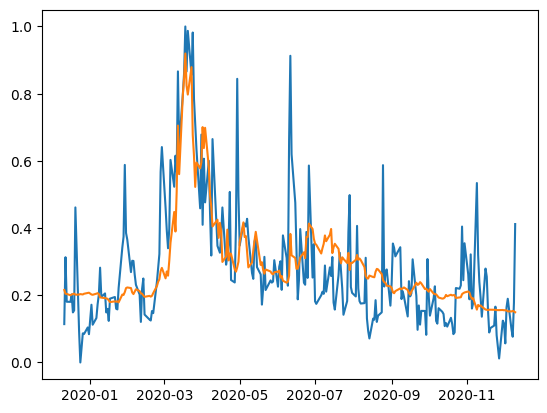

In [73]:
results = model(torch.tensor(X_ss, ).unsqueeze(1).float())
results = results.detach().numpy()
plt.plot(data.index,ms.transform(np.array(data["Volume"]).reshape(-1,1)))
plt.plot(data.index,results)

---